# Pneumonia Classifier
This notebook we will use CNN to train a classifier that will predict Pneumonia using x-ray's as input.  
Use the database from: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia  

## Load the data
Choose SIZE parameter.   
&middot; the size of each image would be (SIZE,SIZE)  
&middot; smaller size could remove too much data and cause underfitting  
&middot; bigger size would slow the calculations significantly, but necessary if you want more complex model    
&middot; default: 127 (also smallest size image on this data)

In [1]:
from PIL import Image
import numpy as np
import os

SIZE = 127

def loadData(path,label):
    count = 0
    Xresult,Yresult,shapes_result = [],[],[]
    for filename in os.listdir(path):
        if filename.endswith(".jpeg"):   
            read_img = np.array(Image.open(path+"/"+filename).convert("L").resize((SIZE,SIZE),Image.LANCZOS))/255.
            Xresult.append(read_img)
            Yresult.append(label)
            shapes_result.append(read_img.shape)
            count += 1
    return np.array(Xresult),Yresult,shapes_result

shapes= []
NORMAL = 0
PNEUMONIA = 1

Xnormal,Ynormal,shapes_normal = loadData('chest_xray/train/NORMAL',NORMAL)
Xpneumonia,Ypneumonia,shapes_pneumonia = loadData('chest_xray/train/PNEUMONIA',PNEUMONIA)
Xtrain = np.vstack((Xnormal,Xpneumonia))
Ytrain = Ynormal + Ypneumonia
shapes = np.vstack((shapes_normal,shapes_pneumonia))

Xnormal,Ynormal,shapes_normal = loadData('chest_xray/test/NORMAL',NORMAL)
Xpneumonia,Ypneumonia,shapes_pneumonia = loadData('chest_xray/test/PNEUMONIA',PNEUMONIA)
Xtest = np.vstack((Xnormal,Xpneumonia))
Ytest = Ynormal + Ypneumonia
shapes = np.vstack((shapes,shapes_normal,shapes_pneumonia))

Xnormal,Ynormal,shapes_normal = loadData('chest_xray/val/NORMAL',NORMAL)
Xpneumonia,Ypneumonia,shapes_pneumonia = loadData('chest_xray/val/PNEUMONIA',PNEUMONIA)
Xval = np.vstack((Xnormal,Xpneumonia))
Yval = Ynormal + Ypneumonia
shapes = np.vstack((shapes,shapes_normal,shapes_pneumonia))

print("input size: ",len(shapes),"\n")
print("Xtrain shape: ",Xtrain.shape)
print("Ytrain size: ",len(Ytrain))
print("Xtest shape: ",Xtest.shape)
print("Ytest size: ",len(Ytest))
print("Xval shape: ",Xval.shape)
print("Yval size: ",len(Yval))

input size:  5856 

Xtrain shape:  (5216, 127, 127)
Ytrain size:  5216
Xtest shape:  (624, 127, 127)
Ytest size:  624
Xval shape:  (16, 127, 127)
Yval size:  16


## Quick analysis on the data
Checking the input size and input quality.

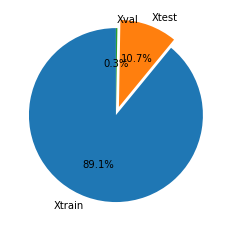

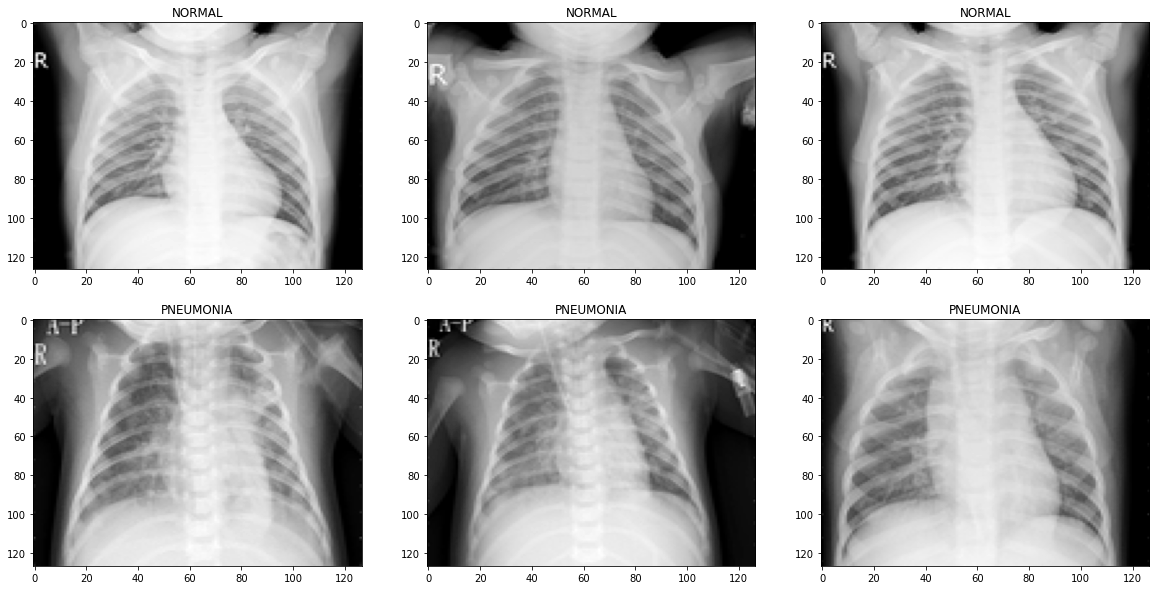

In [2]:
import matplotlib.pyplot as plt

labels = ['Xtrain', 'Xtest', 'Xval']
sizes = [len(Ytrain), len(Ytest), len(Yval)]
explode = (0, 0.1, 0)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)

normalImg,pneImg = [],[]
example_size = 3
for i in range(len(Yval)):
    if len(normalImg) == example_size and len(pneImg) == example_size:
        break
    if len(normalImg) == example_size and Yval[i] == NORMAL:
        continue
    if len(pneImg) == example_size and Yval[i] == PNEUMONIA:
        continue   
    normalImg.append(Xval[i]) if Yval[i] == NORMAL else pneImg.append(Xval[i])

fig2, ax2 = plt.subplots(2,3, figsize=(20,10))
for i in range(example_size):
    ax2[0, i].imshow(normalImg[i], cmap='gray')
    ax2[0, i].set_title("NORMAL")
    ax2[0, i].set_aspect('auto')
    ax2[1, i].imshow(pneImg[i], cmap='gray')
    ax2[1, i].set_title("PNEUMONIA")
    ax2[1, i].set_aspect('auto')
    
plt.show()

## Make new validation set
The size of the validation set is 16 (8 normal, 8 pneumonia),which is too small.    
On the other hand we want the validation set to be dominant and not just mixed with the rest of the data (evaluated by a third expert).  
Choose SPLIT_SIZE parameter.  
&middot; adding SPLIT_SIZE from each group (normal,pneumonia) and from both training and testing set.  
&middot; default: 8 (equal representation from train,test,val and equal normal vs pneumonia representation)

In [3]:
from sklearn.model_selection import train_test_split
from collections import Counter

SPLIT_SIZE = 8

def splitEqual(data,labels,size):
    Xresult = [np.zeros((len(data[0]),len(data[0])))]
    Yresult = []
    count_normal = 0
    count_pneumonia = 0
    i = 0
    while count_normal < size or count_pneumonia < size:
        if (labels[i] == NORMAL and count_normal < size) or (labels[i] == PNEUMONIA and count_pneumonia < size):
            if labels[i] == NORMAL:
                count_normal += 1
            else:
                count_pneumonia += 1
            Xresult = np.append(Xresult,[data[i]],axis = 0)
            Yresult = Yresult+[labels[i]]
            data = np.delete(data,i,axis=0)
            del labels[i]
        else:
            i += 1
    Xresult = np.delete(Xresult,0,axis=0)
    return (data,labels,Xresult,Yresult)

Xtrain,Ytrain,Xval1,Yval1 = splitEqual(Xtrain,Ytrain,SPLIT_SIZE)
Xtest,Ytest,Xval2,Yval2 = splitEqual(Xtest,Ytest,SPLIT_SIZE)
Xval = np.append(Xval,Xval1,axis = 0)
Xval = np.append(Xval,Xval2,axis = 0)
Yval = Yval + Yval1 + Yval2

countTrain,countTest,countVal = Counter(Ytrain),Counter(Ytest),Counter(Yval)
print("train set - normal: ",countTrain[NORMAL]," ,pneumonia: ",countTrain[PNEUMONIA])
print("test set - normal: ",countTest[NORMAL]," ,pneumonia: ",countTest[PNEUMONIA])
print("val set - normal: ",countVal[NORMAL]," ,pneumonia: ",countVal[PNEUMONIA])

train set - normal:  1333  ,pneumonia:  3867
test set - normal:  226  ,pneumonia:  382
val set - normal:  24  ,pneumonia:  24


## More analysis
We should look again at the data.

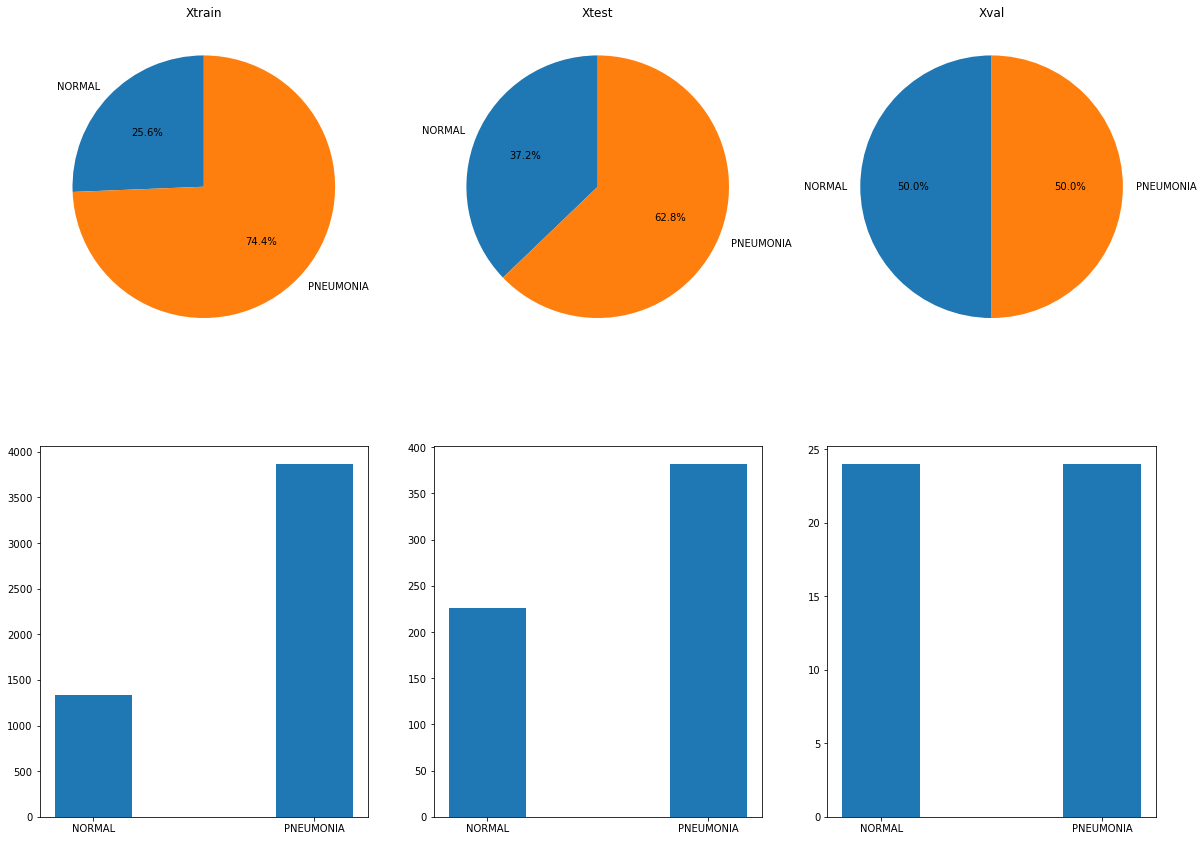

In [4]:
labels = ['NORMAL', 'PNEUMONIA']
sizes = [[countTrain[NORMAL], countTrain[PNEUMONIA]],[countTest[NORMAL], countTest[PNEUMONIA]],[countVal[NORMAL], countVal[PNEUMONIA]]]
titles = ['Xtrain','Xtest','Xval']

fig, ax = plt.subplots(2,3, figsize=(20,15))

for i in range(3):
    ax[0,i].pie(sizes[i], labels=labels, autopct='%1.1f%%', startangle=90)
    ax[0,i].set_title(titles[i])
     
for i in range(3):
    ax[1,i].bar([labels[0],labels[1]], sizes[i], 0.35, label=labels)

plt.show()

## Data Augmentation
Data Augmentation would help us to treat the imbalance of the training set, and give us more samples to learn from.  
&middot; the normal lungs images would be 3 times its original size by applying 2 augmentation per image  
&middot; shuffling the training dataset for randomness     
&middot; resizing all the images to: (SIZE,SIZE,1), to be compatable for conv2D input

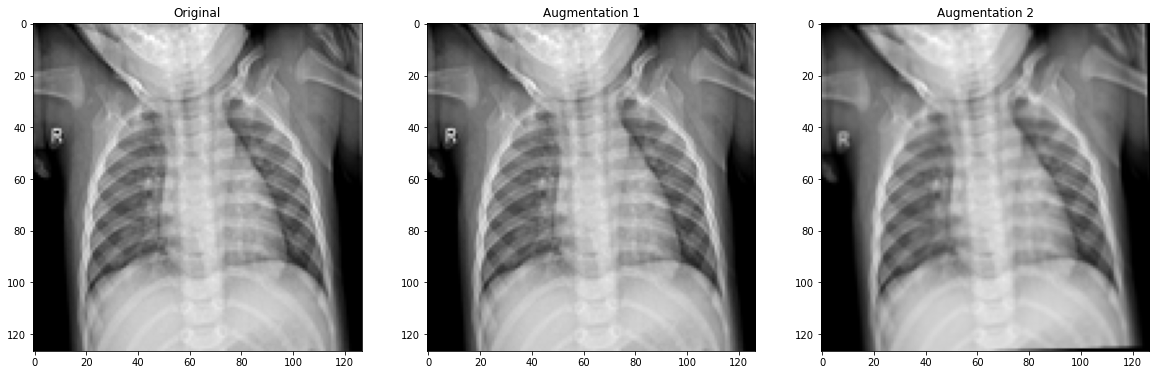

In [5]:
import imgaug.augmenters as iaa

seq1 = iaa.OneOf([
    iaa.GaussianBlur(sigma=(0.1, 0.2)), 
    iaa.LinearContrast((0.95, 1.05)),
])
seq2 = iaa.Sequential([iaa.Affine(rotate=(-2, 2))])

Xaug1 = [seq1.augment_image(Xtrain[i]) for i in range(len(Ytrain)) if Ytrain[i] == NORMAL]
Xaug2 = [seq2.augment_image(Xtrain[i]) for i in range(len(Ytrain)) if Ytrain[i] == NORMAL]
originalNormalImg = [Xtrain[i] for i in range(len(Ytrain)) if Ytrain[i] == NORMAL]

Xtrain = np.vstack((Xtrain,Xaug1,Xaug2))
Ytrain = Ytrain+[NORMAL]*2*Counter(Ytrain)[NORMAL]

Xtrain1, Xtrain2, Ytrain1, Ytrain2 = train_test_split(Xtrain,Ytrain, test_size=0.5, shuffle=True, random_state=42)
Xtrain = np.vstack((Xtrain1,Xtrain2))
Ytrain = Ytrain1+Ytrain2

Xtrain = Xtrain.reshape(len(Xtrain),SIZE,SIZE,1)
Xtest = Xtest.reshape(len(Xtest),SIZE,SIZE,1)
Xval = Xval.reshape(len(Xval),SIZE,SIZE,1)

fig, ax = plt.subplots(1,3, figsize=(20,10))
ax[0].imshow(originalNormalImg[0], cmap='gray')
ax[0].set_title("Original")

ax[1].imshow(Xaug1[0], cmap='gray')
ax[1].set_title("Augmentation 1")

ax[2].imshow(Xaug2[0], cmap='gray')
ax[2].set_title("Augmentation 2")
     
plt.show()

## More analysis
Checking the new balance in each set.

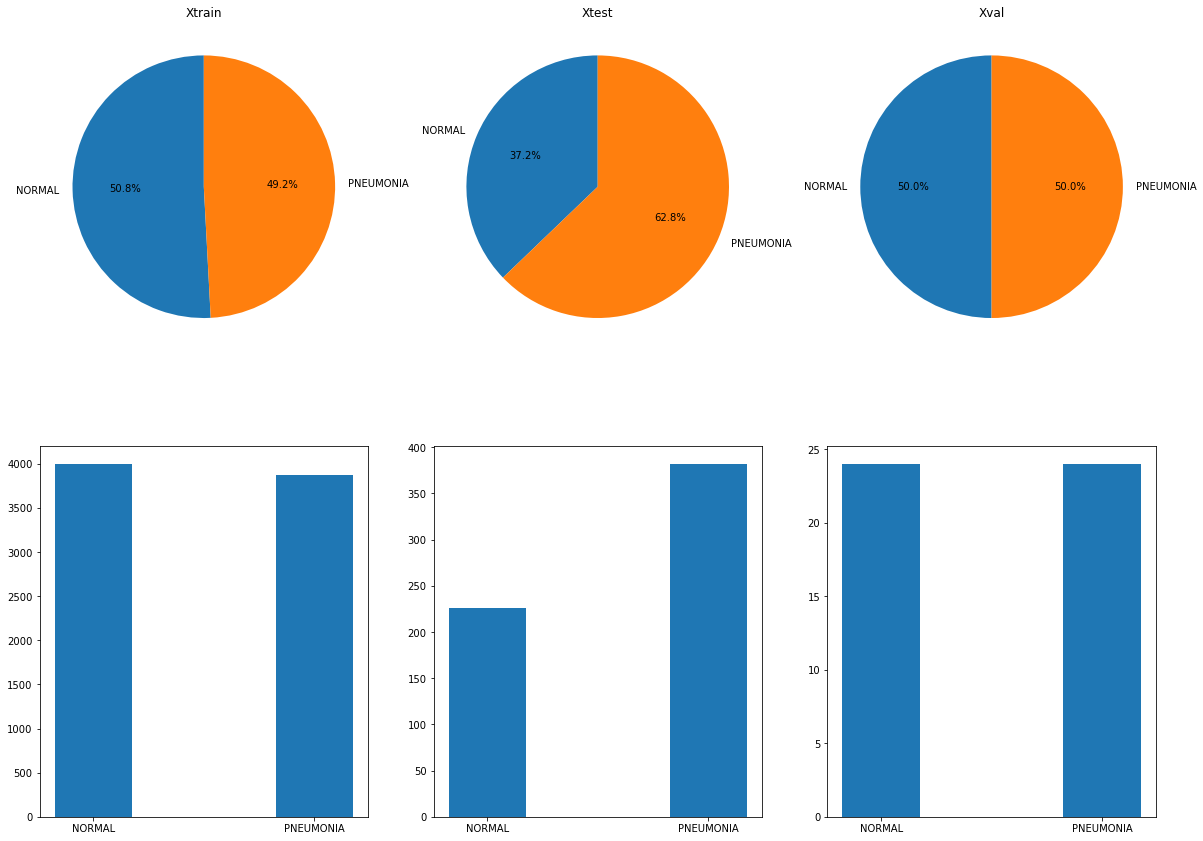

In [6]:
countTrain,countTest,countVal = Counter(Ytrain),Counter(Ytest),Counter(Yval)
labels = ['NORMAL', 'PNEUMONIA']
sizes = [[countTrain[NORMAL], countTrain[PNEUMONIA]],[countTest[NORMAL], countTest[PNEUMONIA]],[countVal[NORMAL], countVal[PNEUMONIA]]]
titles = ['Xtrain','Xtest','Xval']

fig, ax = plt.subplots(2,3, figsize=(20,15))

for i in range(3):
    ax[0,i].pie(sizes[i], labels=labels, autopct='%1.1f%%', startangle=90)
    ax[0,i].set_title(titles[i])
     
for i in range(3):
    ax[1,i].bar([labels[0],labels[1]], sizes[i], 0.35, label=labels)

plt.show()

## Build The Model
Build CNN model.  
&middot; this classification problem easily gets overfitted    
&middot; even easier to get ~100% recall, which is nice (finds all "sick" lungs)    
&middot; the hyperparameters here were chosen to get the best accuracy, on the cost of recall (increased precision)  

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision,Recall
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, InputLayer, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    InputLayer((SIZE, SIZE,1)),
    Conv2D(filters=32,kernel_size=5,strides=2, activation='relu'),
    Dropout(0.2),
    Conv2D(filters=8,kernel_size=3,strides=1,padding="same", activation='relu'),
    MaxPooling2D(pool_size=2,padding="same"),
    Conv2D(filters=16,kernel_size=3,strides=1,padding="same", activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=2,padding="same"),
    Conv2D(filters=32,kernel_size=3,strides=1,padding="same", activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=2,padding="same"),
    Flatten(),
    Dense(128,activation='relu'),
    Dropout(0.5),
    Dense(32,activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss="binary_crossentropy",optimizer=Adam(learning_rate=0.004),metrics=["accuracy",Precision(name='precision'),Recall(name='recall')])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        832       
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 8)         2312      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 16)        1168      
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0

## Fit The Model
With the hyperparameters that were chosen, 'epochs' and 'class_weight' will help to regulate the model.

In [8]:
callback = EarlyStopping(monitor='val_loss', mode='min', patience=5,restore_best_weights=True)
model.fit(Xtrain, np.array(Ytrain), epochs=20, validation_data=(Xval, np.array(Yval)),
          class_weight={NORMAL: 8, PNEUMONIA: 1},callbacks=[callback])

Epoch 1/20
246/246 [==============================] - 55s 225ms/step - loss: 0.9588 - accuracy: 0.6957 - precision: 0.9779 - recall: 0.3897 - val_loss: 0.4102 - val_accuracy: 0.8333 - val_precision: 0.9000 - val_recall: 0.7500
Epoch 2/20
246/246 [==============================] - 55s 224ms/step - loss: 0.5220 - accuracy: 0.8490 - precision: 0.9820 - recall: 0.7057 - val_loss: 0.2836 - val_accuracy: 0.8958 - val_precision: 0.9524 - val_recall: 0.8333
Epoch 3/20
246/246 [==============================] - 55s 222ms/step - loss: 0.4088 - accuracy: 0.8865 - precision: 0.9908 - recall: 0.7763 - val_loss: 0.2592 - val_accuracy: 0.8750 - val_precision: 1.0000 - val_recall: 0.7500
Epoch 4/20
246/246 [==============================] - 62s 253ms/step - loss: 0.3954 - accuracy: 0.8923 - precision: 0.9906 - recall: 0.7885 - val_loss: 0.3116 - val_accuracy: 0.8333 - val_precision: 1.0000 - val_recall: 0.6667
Epoch 5/20
246/246 [==============================] - 59s 242ms/step - loss: 0.3531 - accura

## Evaluate The Model

In [9]:
from sklearn.metrics import confusion_matrix

labels = [0,1]
model.evaluate(Xtest, np.array(Ytest))
confusion_matrix(Ytest,(model.predict(Xtest) > 0.5).astype("int32"),labels=labels)

19/19 [==============================] - 0s 23ms/step - loss: 0.3610 - accuracy: 0.8701 - precision: 0.8651 - recall: 0.9398


array([[170,  56],
       [ 23, 359]], dtype=int64)